# Notebook de Modelado de Clasificación
Este notebook implementa el flujo completo de **clasificación** de locales en 3 categorías (baja, media, alta valoración) con **Random Forest**.
Incluye comentarios en los puntos clave y paths absolutos para evitar errores.

## Imports y configuración inicial

In [10]:
# Importar librerías básicas
import pandas as pd  # para manejo de datos
import numpy as np   # para cálculos numéricos
import matplotlib.pyplot as plt  # para gráficos

# Scikit-learn: modelos y utilidades
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, learning_curve, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay, auc)
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import randint  # para RandomizedSearch
import joblib  # para guardar/cargar modelos

# Ajustes de visualización
plt.rcParams['figure.figsize'] = (6, 4)


## 1. Carga de datos

In [11]:
# Ruta absoluta al CSV procesado (evita errores de directorio)
DATA_PATH = '../data/MAPS_locales_procesado.csv'
df = pd.read_csv(DATA_PATH)
df.head()  # Mostrar primeras filas

,nombre,direccion,codigo_postal,puntuacion_media,numero_reviews,tipo_negocio,latitud,longitud,categoria_negocio
0,Hotel NH Collection Madrid Colón,"Calle del Marqués de Zurgena, 4, Madrid",28001,4.6,1495.0,"lodging, point_of_interest, establishment",40.426076,-3.689070,Alojamiento
1,Rosewood Villa Magna,"Paseo de la Castellana, 22, Madrid",28001,4.5,2651.0,"gym, lodging, spa, health, restaurant, food, p...",40.429952,-3.688152,Restauración
2,Hotel Único Madrid,"Calle de Claudio Coello, 67, Madrid",28001,4.7,527.0,"lodging, restaurant, food, point_of_interest, ...",40.428537,-3.686331,Restauración
3,Hotel Fénix Gran Meliá - The Leading Hotels of...,"Calle de Hermosilla, 2, Madrid",28001,4.6,1673.0,"lodging, point_of_interest, establishment",40.426552,-3.689210,Alojamiento
4,H10 Puerta de Alcalá,"Calle Alcalá, 66, Madrid",28001,4.4,2831.0,"lodging, point_of_interest, establishment",40.422182,-3.681154,Alojamiento


## 2. Feature Engineering y creación de la variable objetivo

In [12]:
# 2.1 Recalcular valoración ponderada (si no está en CSV)
df['valoracion'] = df['puntuacion_media'] * (1 - np.exp(-df['numero_reviews'] / 10))

# 2.2 Normalización Min–Max por categoría
df['valoracion_norm'] = (
    df.groupby('categoria_negocio')['valoracion']
      .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

# 2.3 Crear la variable categórica en 3 clases según cuantiles
df['clase_val'] = pd.qcut(
    df['valoracion_norm'], q=3,
    labels=['baja', 'media', 'alta']
)
df['clase_val'].value_counts()  # Distribución de clases

clase_val
baja     969
alta     958
media    949
Name: count, dtype: int64

## 3. Definición de variables

In [13]:
# Selección de features y target
X = df[['latitud', 'longitud', 'categoria_negocio']]
y = df['clase_val']

## 4. División Train/Test

In [14]:
# División estratificada para mantener proporciones de clases
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 5. Preprocesado y Pipeline con RandomForestClassifier

In [15]:
# Definir preprocessing pipes
num_feats = ['latitud', 'longitud']
cat_feats = ['categoria_negocio']

# Escalado para numéricos
num_pipe = Pipeline([('scaler', StandardScaler())])

# One-Hot para categóricos (sparse_output para sklearn>=1.2)
cat_pipe = Pipeline([('onehot', OneHotEncoder(drop='first', sparse_output=False))])

# ColumnTransformer que aplica a cada tipo
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats),
])

# Pipeline completo: preprocesado + modelo
clf = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

## 6. Entrenamiento y evaluación básica

In [16]:
# Ajustar el modelo
clf.fit(X_tr, y_tr)

# Predicciones
y_pred = clf.predict(X_te)
y_proba = clf.predict_proba(X_te)

# Métricas de clasificación
print("Accuracy:", accuracy_score(y_te, y_pred))
print("\nClassification Report:\n", classification_report(y_te, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))

# ROC-AUC multiclass (one-vs-rest)
auc_score = roc_auc_score(y_te, y_proba, multi_class='ovr')
print("ROC-AUC (OVR):", auc_score)

Accuracy: 0.7465277777777778

Classification Report:
               precision    recall  f1-score   support

        alta       0.77      0.74      0.76       192
        baja       0.72      0.78      0.75       194
       media       0.75      0.72      0.74       190

    accuracy                           0.75       576
   macro avg       0.75      0.75      0.75       576
weighted avg       0.75      0.75      0.75       576

Confusion Matrix:
 [[142  31  19]
 [ 17 151  26]
 [ 25  28 137]]
ROC-AUC (OVR): 0.8656393084718678


## 6.1 Importancia de Features

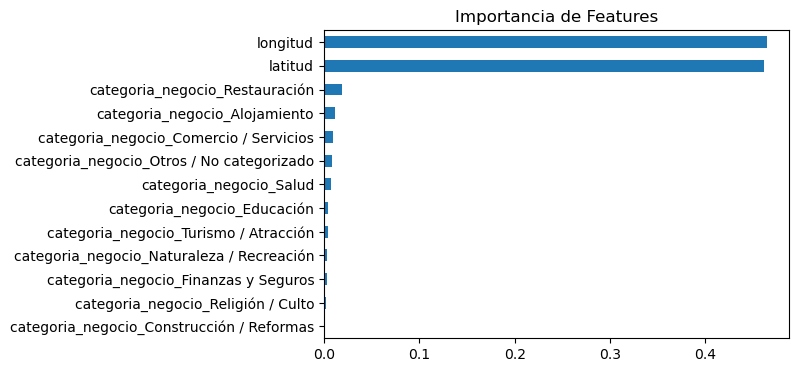

In [17]:
# Extraer nombres de features tras One-Hot Encoding
onehot = clf.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
feat_names = num_feats + list(onehot.get_feature_names_out(cat_feats))

# Extraer y graficar importancias
importances = pd.Series(
    clf.named_steps['rf'].feature_importances_,
    index=feat_names
)
importances.sort_values().plot.barh()
plt.title("Importancia de Features")
plt.show()

## 6.2 Matriz de confusión promedio (CV)

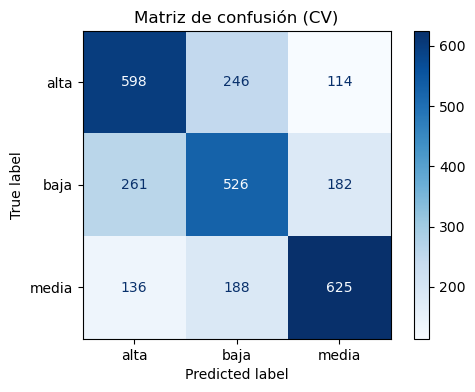

In [18]:
# Usamos cross_val_predict con la variable y ya definida
y_pred_cv = cross_val_predict(clf, X, y, cv=5)

# Matriz de confusión
cm = confusion_matrix(y, y_pred_cv, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión (CV)")
plt.show()

## 6.3 Calibración de probabilidades (opcional)

In [19]:
# Calibrar probabilidades para mejorar AUC
calib = CalibratedClassifierCV(clf, cv=5, method='isotonic')
calib.fit(X, y)

# Evaluar AUC calibrado
cv_auc_calib = cross_val_score(
    calib, X, y, cv=5, scoring='roc_auc_ovr'
).mean()
print("AUC CV calibrado:", cv_auc_calib)

AUC CV calibrado: 0.7695511733175504


## 6.4 Curvas de aprendizaje

/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^

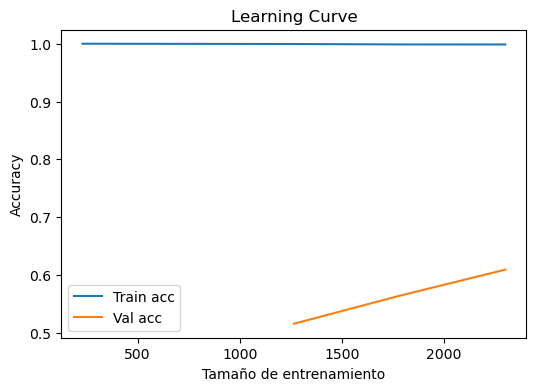

In [20]:
# Learning curve para diagnosticar under/over-fitting
train_sizes, train_scores, val_scores = learning_curve(
    clf, X, y,
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Train acc')
plt.plot(train_sizes, val_mean,   label='Val acc')
plt.xlabel("Tamaño de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

## 7. Curvas ROC por clase

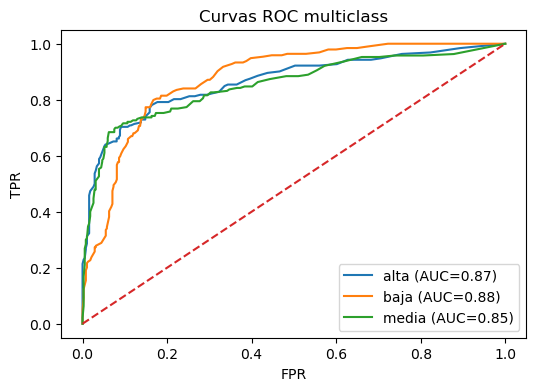

In [21]:
# Binarizar etiquetas y graficar ROC por clase
classes = clf.classes_
y_bin = label_binarize(y_te, classes=classes)

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC multiclass")
plt.legend()
plt.show()

## 8. Validación cruzada

In [22]:
# Metrics CV para accuracy y AUC
cv_acc = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Acc CV: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

cv_auc = cross_val_score(clf, X, y, cv=5, scoring='roc_auc_ovr')
print(f"AUC CV: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

Acc CV: 0.608 ± 0.071
AUC CV: 0.766 ± 0.066


## 9. Búsqueda de hiperparámetros

In [23]:
# RandomizedSearch para ajustar hiperparámetros
param_dist = {
    'rf__n_estimators': randint(50, 300),
    'rf__max_depth': randint(3, 20),
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__min_samples_split': randint(2, 10),
}

rand_search = RandomizedSearchCV(
    clf, param_distributions=param_dist,
    n_iter=30, cv=5,
    scoring='accuracy',
    random_state=42, n_jobs=-1
)
rand_search.fit(X_tr, y_tr)

print("Mejor accuracy CV:", rand_search.best_score_)
print("Mejores parámetros:", rand_search.best_params_)

# Actualizar pipeline al mejor estimador
clf = rand_search.best_estimator_

/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alberto/miniconda3/envs/evolve/l

Mejor accuracy CV: 0.6839130434782608
Mejores parámetros: {'rf__max_depth': 19, 'rf__max_features': 'log2', 'rf__min_samples_split': 4, 'rf__n_estimators': 219}


## 10. Guardado del clasificador

In [24]:
# Guardar el modelo entrenado en carpeta 'models'
joblib.dump(clf, '../models/rf_classifier.pkl')
print("Clasificador guardado en models/rf_classifier.pkl")

Clasificador guardado en models/rf_classifier.pkl
